In [1]:
from utils.imports import *

Using TensorFlow backend.


In [2]:
csv_path = PATH['annotations_train']

In [3]:
train_pred = pd.read_csv(csv_path + "0final.csv")

In [4]:
train_true = train_pred[train_pred['True']==1]
train_false = train_pred[train_pred['True']==0]
train_false = train_false[train_false.index%4 == 0]

In [5]:
train_pred = pd.concat([train_true,train_false],axis=0)

In [6]:
train_pred = train_pred.drop(['seriesuid','coordX','coordY','coordZ','file'],axis=1)

In [7]:
train = train_pred[['diameter_mm','probability_30_30_30_cube','probability_06_20_20','probability_10_30_30','probability_26_40_40','True']]
test = train_pred[['diameter_mm','probability_30_30_30_cube','probability_06_20_20','probability_10_30_30','probability_26_40_40','True']]
sample = train_pred[['diameter_mm','probability_30_30_30_cube','probability_06_20_20','probability_10_30_30','probability_26_40_40','True']]

In [8]:
features = list(train.columns[1:-1])  #la colonne 0 est le quote_conversionflag  

In [9]:
xgb_model = xgb.XGBClassifier()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05,0.005,0.0005,0.5,0.1,0.001,0.0001,0.01], #so called `eta` value
              'max_depth': [6,8,11,13,17,21,25],
              'min_child_weight': [5,7,9,11,13,15,],
              'silent': [1],
              'subsample': [1],
              'n_estimators': [2000], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(train['True'], n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=1, refit=True)

clf.fit(train[features], train["True"])

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

#sample = pd.read_csv('../input/sample_submission.csv')
sample['probability'] = test_probs
#sample.to_csv("xgboost_best_parameter_submission.csv", index=False)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   14.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 13.1min
[Parallel(n_jobs=5)]: Done 1680 out of 1680 | elapsed: 18.7min finished


('Raw AUC score:', 0.5466228606744479)
learning_rate: 0.5
max_depth: 21
min_child_weight: 13
n_estimators: 2000
nthread: 4
objective: 'binary:logistic'
seed: 1337
silent: 1
subsample: 1


In [10]:
test_probs.shape

(2309,)

In [11]:
aa = clf.predict_proba(test[features])

([array([ 1073.,   133.,    22.,    10.,    11.,     2.,     7.,    21.,
           147.,   883.]),
  array([  883.,   147.,    21.,     7.,     2.,    11.,    10.,    22.,
           133.,  1073.])],
 array([  9.11084317e-06,   1.00007288e-01,   2.00005465e-01,
          3.00003642e-01,   4.00001819e-01,   4.99999996e-01,
          5.99998173e-01,   6.99996350e-01,   7.99994527e-01,
          8.99992704e-01,   9.99990880e-01]),
 <a list of 2 Lists of Patches objects>)

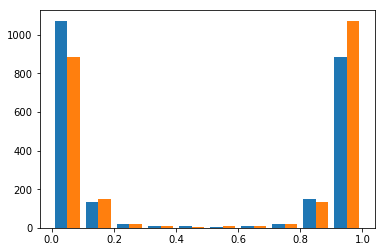

In [12]:
%matplotlib inline
plt.hist(aa,bins = 10)